In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [131]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')

In [132]:
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode"])
df.head()

,Report_TransactionEffectiveDate,TransactionGroup,TransactionAmount
0,2013-12-30,D,-972.619715
1,2013-12-30,D,-75.956876
2,2013-12-30,C,127.430470
3,2013-12-30,D,-38.300469
4,2013-12-30,D,-117.467137


In [133]:
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df.head()

,TransactionGroup,TransactionAmount
Report_TransactionEffectiveDate,,
2013-12-30,D,-972.619715
2013-12-30,D,-75.956876
2013-12-30,C,127.430470
2013-12-30,D,-38.300469
2013-12-30,D,-117.467137


In [134]:
## Create Debit and Credit df
credit_df = df[df["TransactionGroup"] == "C"].groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D')
debit_df = df[df["TransactionGroup"] == "D"].groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D')

## Fill missing values
credit_df = credit_df.fillna(method='ffill').fillna(method='bfill')
debit_df = debit_df.fillna(0)

In [135]:
# Find best sarima params
def find_best_sarima_params(data, seasonal=True, m=4):
    model = auto_arima(data, seasonal=seasonal, m=m, stepwise=True, suppress_warnings=True, trace=False)
    return model.order, model.seasonal_order

credit_order, credit_seasonal= find_best_sarima_params(credit_df)
debit_order, debit_seasonal= find_best_sarima_params(debit_df)
print("Credit Order: ", credit_order)
print("Credit Seasonal: ", credit_seasonal)
print("Debit Order: ", debit_order)
print("Debit Seasonal: ", debit_seasonal)

Credit Order:  (5, 1, 5)
Credit Seasonal:  (2, 0, 2, 7)
Debit Order:  (5, 0, 0)
Debit Seasonal:  (2, 0, 1, 7)


In [136]:
def fit_arima_model(data, order, seasonal):
    model = SARIMAX(data, order=order, seasonal=seasonal, enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit(disp=False)
    return results

credit_model_test = fit_arima_model(credit_df, credit_order, credit_seasonal)
debit_model_test = fit_arima_model(debit_df, debit_order, debit_seasonal)

In [150]:
def evaluate_model(model, actual_data, label):
    predicted = model.fittedvalues
    residuals = actual_data - predicted
    mae = mean_absolute_error(actual_data, predicted)
    rmse = np.sqrt(mean_squared_error(actual_data, predicted))
    print(f"{label} Model Evaluation: MAE={mae:.2f}, RMSE={rmse:.2f}")
    
    plt.figure(figsize=(12, 5))
    plt.plot(residuals, label=f'{label} Residuals')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residual Plot for {label} Transactions')
    plt.legend()
    plt.show()
    return mae, rmse
    

In [151]:
# credit_forecast = credit_model_test.forecast(steps=len(credit_order))
# debit_forecast = debit_model_test.forecast(steps=len(debit_df))

Credit Model Evaluation: MAE=12562.08, RMSE=17656.64


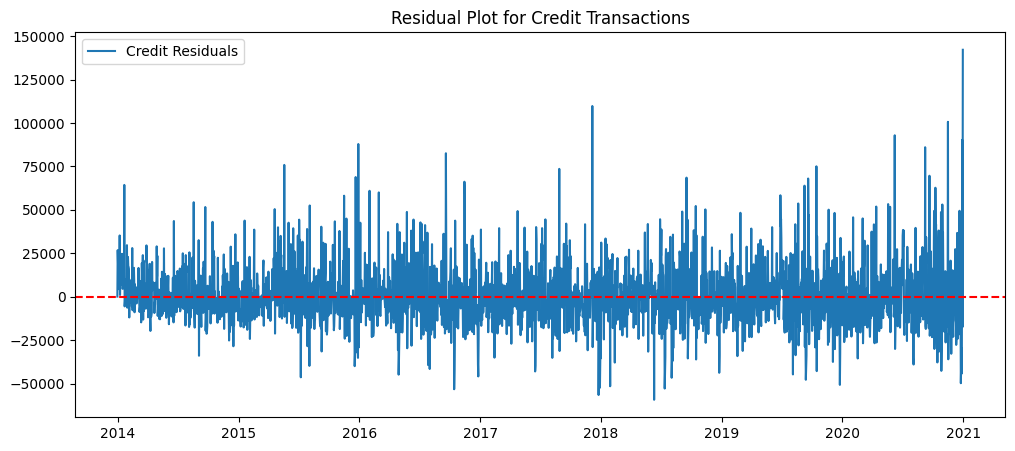

Debit Model Evaluation: MAE=16655.85, RMSE=21532.42


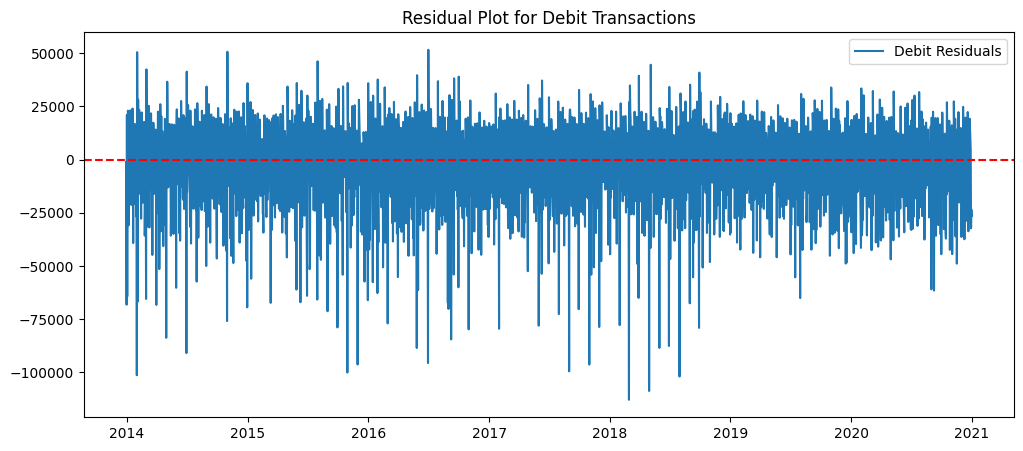

In [152]:
credit_mae, credit_rmse = evaluate_model(credit_model_test, credit_df, "Credit")
debit_mae, debit_rmse = evaluate_model(debit_model_test, debit_df, "Debit")


In [140]:
# forecast_index = pd.date_range(start=credit_df.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
# forecasts_df = pd.DataFrame({
#     'credit_forecast': credit_forecast,
#     'debit_forecast': debit_forecast,
#     'total_forecast': credit_forecast + debit_forecast  # Total transaction forecast
# }, index=forecast_index)


In [141]:
# Confidence Intervals
# credit_ci = credit_model.get_forecast(steps=forecast_steps).conf_int()
# debit_ci = debit_model.get_forecast(steps=forecast_steps).conf_int()
# forecasts_df['credit_lower_ci'] = credit_ci.iloc[:, 0]
# forecasts_df['credit_upper_ci'] = credit_ci.iloc[:, 1]
# forecasts_df['debit_lower_ci'] = debit_ci.iloc[:, 0]
# forecasts_df['debit_upper_ci'] = debit_ci.iloc[:, 1]

In [142]:
## Evaluate model
